In [102]:
# Google Drive マウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [0]:
def deg2rad(x):
    return x * np.pi/180

In [0]:
def rad2deg(x):
    return x * 180/np.pi

In [0]:
def omega2deg(x, bias=0):
    return (np.cumsum(x) + 180 + bias) % 360 - 180

In [0]:
def timeSub(time1, time2):
    return (time1 - time2).total_seconds()

In [0]:
def calcDistance(latitude1, longitude1, latitude2, longitude2):
    GRS80_A = 6378137.000  # 長半径 a(m)
    GRS80_E2 = 0.00669438002301188  # 第一遠心率  eの2乗
    R = 6378137  # 赤道半径[m]

    my = deg2rad((latitude1 + latitude2) / 2.0)

    # 卯酉線曲率半径を求める(東と西を結ぶ線の半径)
    sinMy = np.sin(my)
    w = np.sqrt(1.0 - GRS80_E2 * sinMy * sinMy)
    n = GRS80_A / w

    # 子午線曲線半径を求める(北と南を結ぶ線の半径)
    mnum = GRS80_A * (1 - GRS80_E2)
    m = mnum / (w * w * w)

    deltaLatitude = deg2rad(latitude2 - latitude1)
    deltaLongitude = deg2rad(longitude2 - longitude1)

    deltaX = n * np.cos(my) * deltaLongitude
    deltaY = m * deltaLatitude
    distance = (deltaX ** 2 + deltaY ** 2) ** 0.5
    angle = np.arctan2(-deltaY, -deltaX)
    return distance, angle

In [0]:
# ローパスフィルタ（移動平均）
def LPF(x, num=5):
    coefficient = np.ones(num) / num
    y = np.convolve(x, coefficient, mode='same')  # 移動平均
    return y

In [0]:
folder = 'drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML/'

# filename = '0912_1800'
# filename = '0912_1815'
# filename = '0925'
# filename = '1010'
# filename = '1104_1607'
# filename = '1104_1650'
# filename = '1104_1744'
# filename = '1106_1059'
# filename = '1106_1120'
filename = '1106_1136'
# filename = '1106_1152'

In [111]:
# 加速度データの読み込み
df_acc = pd.read_csv(folder + 'data/acc/' + filename + 'acc.csv')
df_acc.set_index('datetime', inplace=True)
df_acc.index = pd.to_datetime(df_acc.index)

print(df_acc.keys())

Index(['accX[m/s^2]', 'accY[m/s^2]', 'accZ[m/s^2]', 'gyroX[rad/s]',
       'gyroY[rad/s]', 'gyroZ[rad/s]', 'angleX[rad]', 'angleY[rad]',
       'angleZ[rad]', 'step'],
      dtype='object')


In [112]:
# RTKデータの読み込み
df_rtk = pd.read_csv(folder + 'data/rtk/csv/' + filename + 'rtk.csv')
df_rtk['datetime'] = df_rtk['date'] + ' ' + df_rtk['time']
df_rtk.set_index('datetime', inplace=True)
df_rtk.index = pd.to_datetime(df_rtk.index)
df_rtk.index += datetime.timedelta(hours=9)
df_rtk.index -= datetime.timedelta(seconds=18)

# 速度算出
speed_list = [0]
angle_list = [0]
for i in range(1, df_rtk.shape[0]):
    if i == 1: elapsedTime = timeSub(df_rtk.index[i], df_rtk.index[0])
    else:      elapsedTime = timeSub(df_rtk.index[i], df_rtk.index[i-1])
    distance, angle = calcDistance(df_rtk['latitude(deg)'][i-1],
                                   df_rtk['longitude(deg)'][i-1],
                                   df_rtk['latitude(deg)'][i],
                                   df_rtk['longitude(deg)'][i]) 
    speed = distance / elapsedTime
    speed_list.append(speed)
    angle_list.append(angle)
df_rtk['speed'] = speed_list
df_rtk['angle'] = angle_list

print(df_rtk.keys())

Index(['date', 'time', 'latitude(deg)', 'longitude(deg)', 'height(m)', 'Q',
       'ns', 'sdn(m)', 'sde(m)', 'sdu(m)', 'sdne(m)', 'sdeu(m)', 'sdun(m)',
       'age(s)', 'ratio', 'speed', 'angle'],
      dtype='object')


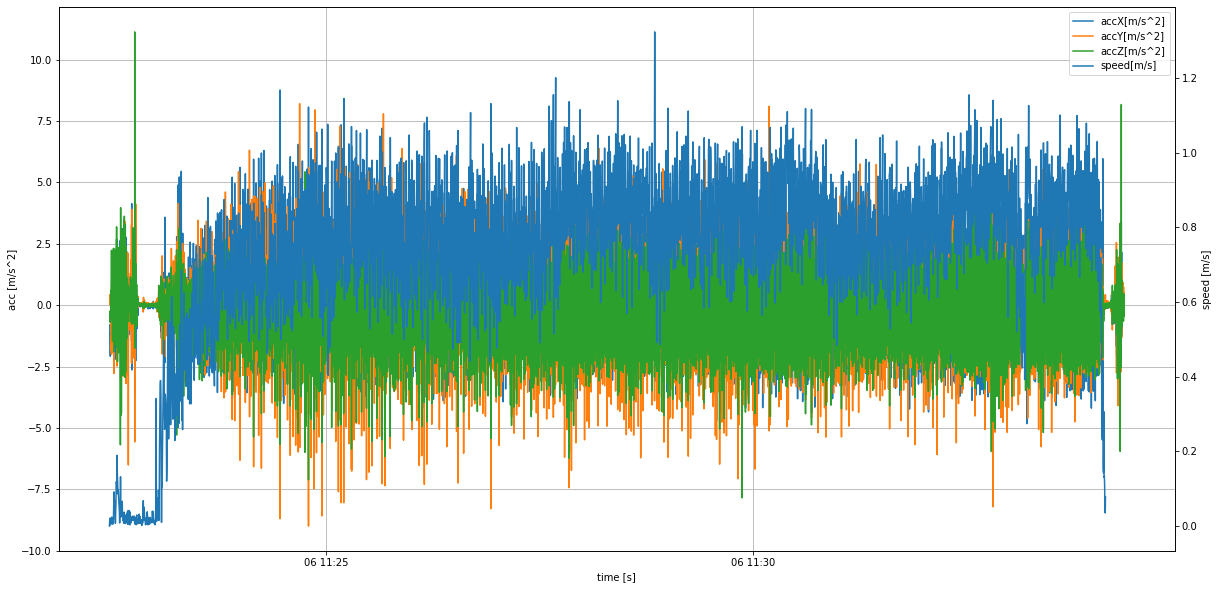

In [113]:
# グラフ表示
fig = plt.figure(facecolor='white', figsize=(20, 10))

ax1 = fig.add_subplot(111)
ax1.plot(df_acc.index, df_acc['accX[m/s^2]'], label='accX[m/s^2]')
ax1.plot(df_acc.index, df_acc['accY[m/s^2]'], label='accY[m/s^2]')
ax1.plot(df_acc.index, df_acc['accZ[m/s^2]'], label='accZ[m/s^2]')

ax2 = ax1.twinx()
ax2.plot(df_rtk.index, df_rtk['speed'], label='speed[m/s]')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='upper right')

ax1.set_xlabel('time [s]')
ax1.set_ylabel('acc [m/s^2]')
ax2.set_ylabel('speed [m/s]')
ax1.grid()

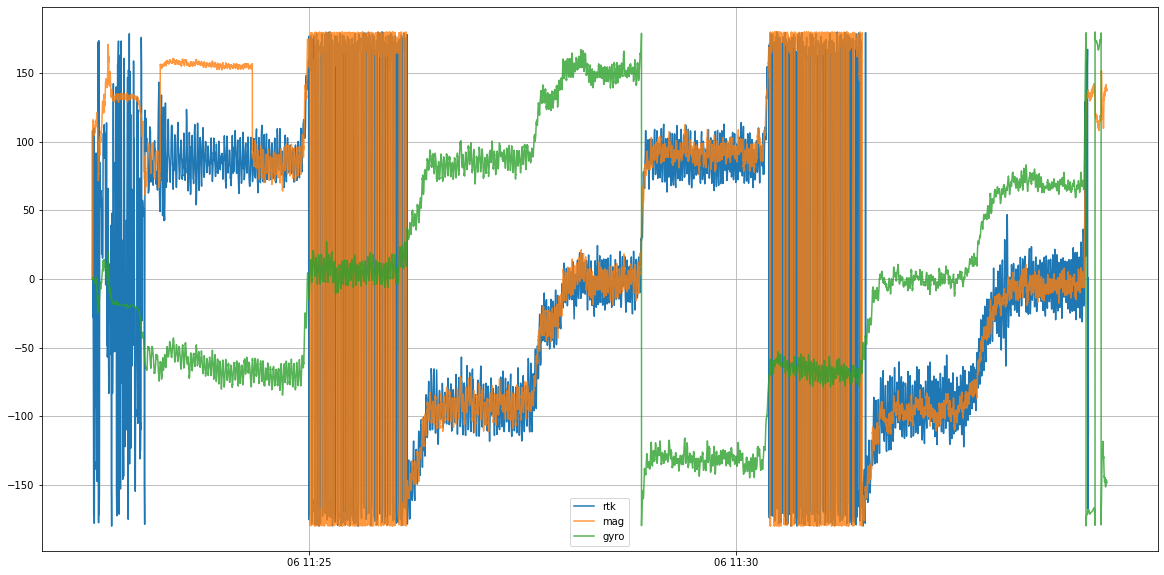

In [114]:
# グラフ表示
plt.figure(facecolor='white', figsize=(20, 10))
plt.plot(df_rtk.index, rad2deg(df_rtk['angle']), label='rtk')
plt.plot(df_acc.index, rad2deg(df_acc['angleZ[rad]']), label='mag', alpha=0.8)
angleByGyro = omega2deg(df_acc['gyroX[rad/s]'])
plt.plot(df_acc.index, angleByGyro, label='gyro', alpha=0.8)
plt.legend()
plt.grid()

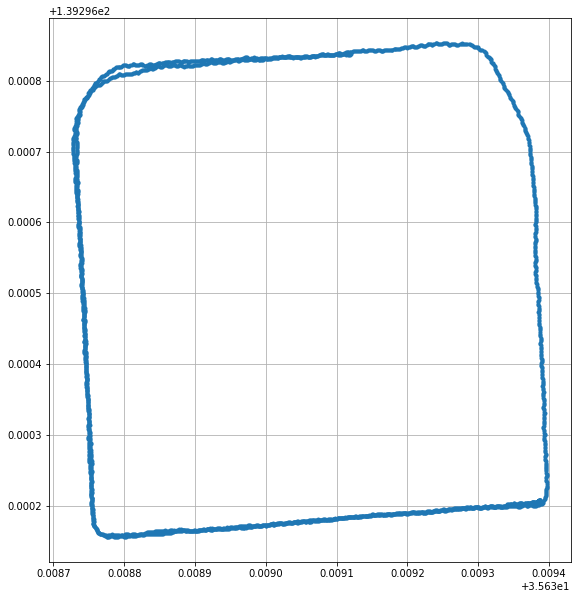

In [115]:
# グラフ表示
fig = plt.figure(facecolor='white', figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax1.plot(df_rtk['latitude(deg)'][:1*60*50], df_rtk['longitude(deg)'][:1*60*50], marker='.')
ax1.set_aspect('equal')
plt.grid()

In [0]:
Xlist = [0.0]
Ylist = [0.0]
Xlist_gyro = [0.0]
Ylist_gyro = [0.0]
stride = 0.5
for i in range(1, df_acc.shape[0]):
    if df_acc['step'][i] - df_acc['step'][i-1] > 0:
        Xlist.append(Xlist[-1] + stride * np.cos(df_acc['angleZ[rad]'][i]))
        Ylist.append(Ylist[-1] + stride * np.sin(df_acc['angleZ[rad]'][i]))
        Xlist_gyro.append(Xlist_gyro[-1] + stride * np.cos(deg2rad(angleByGyro[i])))
        Ylist_gyro.append(Ylist_gyro[-1] + stride * np.sin(deg2rad(angleByGyro[i])))

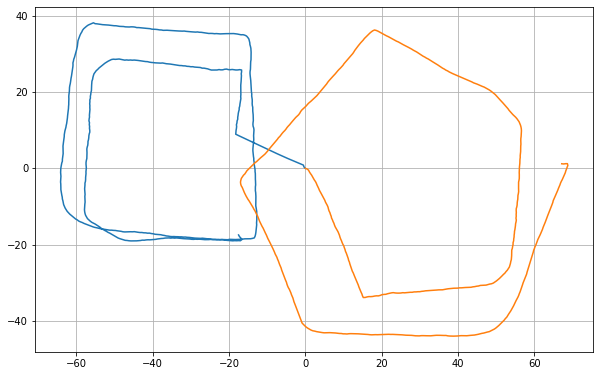

In [117]:
# グラフ表示
fig = plt.figure(facecolor='white', figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax1.plot(Xlist, Ylist)
ax1.plot(Xlist_gyro, Ylist_gyro)
ax1.set_aspect('equal')
plt.grid()

In [0]:
class ParticleFilter(object):
    def __init__(self, particle_num):
        self.particles = {}
        self.particles['value'] = np.linspace(-180, 180, particle_num)
        self.particles['weight'] = np.ones(particle_num) / particle_num
        self.particle_num = particle_num

    def likelihood(self, deg, gyro, mag):
        return norm.pdf(deg, gyro, 5) + norm.pdf(deg, mag, 5)

    def resample(self):
        particles_value_copy = self.particles['value'].copy()
        weights = self.particles['weight'].cumsum()
        for i in range(self.particle_num):
            weight = np.random.rand() * weights[-1]
            self.particles['value'][i] = particles_value_copy[(weights > weight).argmax()]
            self.particles['weight'][i] = 1.0

    def predict(self, variance=1.0):
        self.particles['value'] += np.random.randn(self.particle_num) * variance

    def weight(self, gyro, mag): 
        for i in range(self.particle_num): 
            self.particles['weight'][i] = self.likelihood(self.particles['value'][i], gyro, mag)
        sum_weight = self.particles['weight'].sum()
        self.particles['weight'] *= self.particle_num / sum_weight

    def particleFilter(self, gyro, mag):
        particles_data = {}
        particles_data['values'] = [self.particles['value'].copy()]
        particles_data['weight'] = [self.particles['weight'].copy()]
        particles_data['value'] = [0.0]
        for t in range(len(gyro)):
            print('\r calculating... {0}/{1}'.format(t+1, len(gyro)), end='')
            self.resample()
            self.predict(10)
            if t == 0: gyrovalue = gyro[t]
            else:      gyrovalue = particles_data['value'][-1] + gyro[t]
            self.weight(gyrovalue, mag[t])
            particles_data['values'].append(self.particles['value'].copy())
            particles_data['weight'].append(self.particles['weight'].copy())
            value = np.average(self.particles['value'], weights=self.particles['weight'])
            particles_data['value'].append(value)
        return particles_data

In [152]:
pf = ParticleFilter(10)
start = 10
border = 1000 + start
# pf_data = pf.particleFilter(angleByGyro[:border], rad2deg(df_acc['angleZ[rad]'])[:border])
pf_data = pf.particleFilter(df_acc['gyroX[rad/s]'][start:border], rad2deg(df_acc['angleZ[rad]'])[start:border])

 calculating... 1000/1000

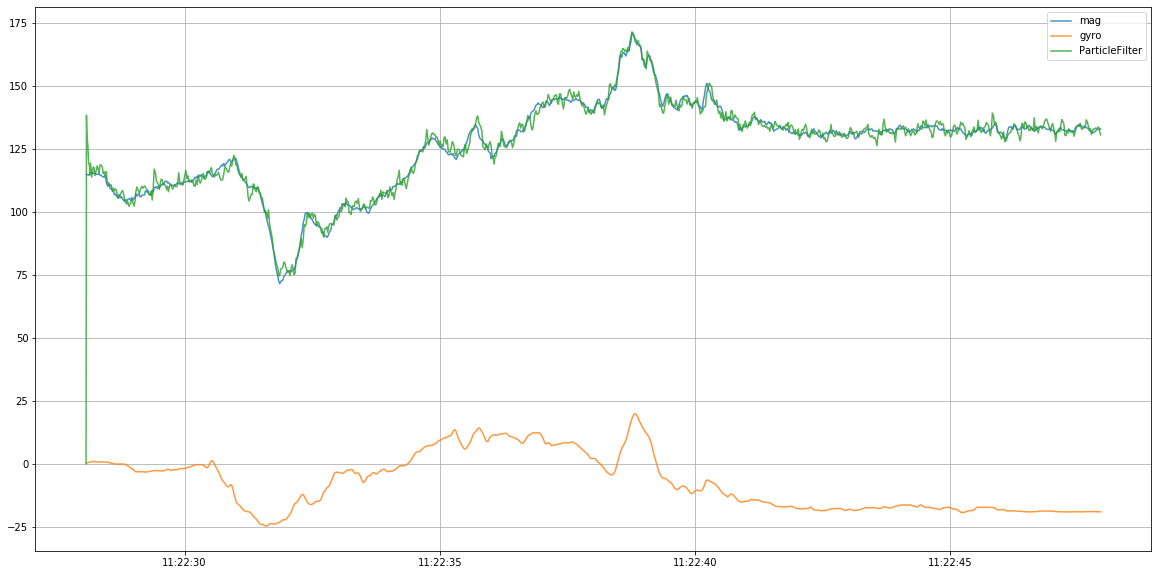

In [153]:
# グラフ表示
plt.figure(facecolor='white', figsize=(20, 10))
# plt.plot(df_rtk.index, rad2deg(df_rtk['angle']), label='rtk')
plt.plot(df_acc.index[start:border], rad2deg(df_acc['angleZ[rad]'])[start:border], label='mag', alpha=0.8)
plt.plot(df_acc.index[start:border], angleByGyro[start:border], label='gyro', alpha=0.8)
plt.plot(df_acc.index[start-1:border], pf_data['value'], label='ParticleFilter', alpha=0.8)
# for t in range(len(pf_data['values'])):
#     for i in range(len(pf_data['values'][0])):
#         plt.scatter(df_acc.index[start-1:border][t], pf_data['values'][t][i], color='red', alpha=0.5, s=20*pf_data['weight'][t][i])
plt.legend()
plt.grid()